# Phase 2 Project Notebook -- Jamie Dowat 

#### Project Goals:

* Develop at least 2 variables that are well-modeled with price.
* At least 3 polished visualizations, including a QQ plot

#### Column Definitions
* View:
* Condition
* Grade


## Data Understanding

[Data Source](https://info.kingcounty.gov/assessor/DataDownload/default.aspx)

In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('../src/kc_house_data.csv')

In [71]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [72]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [73]:
wtrfront_mean = df['waterfront'].mean()

In [74]:
wtrfront_mean

0.007595858696217679

In [75]:
df.sqft_above.dtype

dtype('int64')

In [76]:
df.waterfront.fillna(wtrfront_mean, inplace=True)

In [77]:
basement_nums = df['sqft_basement'][df['sqft_basement']!='?'].map(lambda x: float(x))
basement_mean = basement_nums.mean()
df['sqft_basement'][df['sqft_basement']=='?'] = df['sqft_basement'][df['sqft_basement']=='?'].map(lambda x: x.replace(x, str(basement_mean)))

<ipython-input-77-1e6941f9a541>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sqft_basement'][df['sqft_basement']=='?'] = df['sqft_basement'][df['sqft_basement']=='?'].map(lambda x: x.replace(x, str(basement_mean)))


In [78]:
df['sqft_basement'].value_counts()

0.0                 12826
291.851723974838      454
600.0                 217
500.0                 209
700.0                 208
                    ...  
768.0                   1
2500.0                  1
516.0                   1
1281.0                  1
1880.0                  1
Name: sqft_basement, Length: 304, dtype: int64

Deleting outlier: [source](https://blue.kingcounty.com/Assessor/eRealProperty/Dashboard.aspx?ParcelNbr=2402100895)

In [79]:
df[df['id']==2402100895]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,7,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


In [80]:
df.drop(index=15856, inplace=True)

In [81]:
df[df['id']==2402100895]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [82]:
# dropping view and yr_renovated
df.drop(labels=['view', 'yr_renovated'], axis=1, inplace=True)

In [83]:
df.corr().price.sort_values(ascending=False)

price            1.000000
sqft_living      0.701929
grade            0.667964
sqft_above       0.605392
sqft_living15    0.585267
bathrooms        0.525915
bedrooms         0.315961
lat              0.306687
waterfront       0.264117
floors           0.256820
sqft_lot         0.089879
sqft_lot15       0.082849
yr_built         0.053965
condition        0.036031
long             0.022047
id              -0.016763
zipcode         -0.053409
Name: price, dtype: float64

### Engineering Variables

##### New Column : Price_per_sqft

In [84]:
df['price_per_sqft'] = df['price'] / df['sqft_living']

In [85]:
df[df['price_per_sqft']==df['price_per_sqft'].max()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft
19321,6021500970,4/7/2015,874950.0,2,1.0,1080,4000,1.0,0.0,3,7,1080,291.851723974838,1940,98117,47.6902,-122.387,1530,4240,810.138889


In [86]:
df[df['price_per_sqft']==df['price_per_sqft'].min()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price_per_sqft
18248,2891000610,12/11/2014,148900.0,4,1.75,1700,6000,1.0,0.0,3,7,1700,0.0,1967,98002,47.3252,-122.208,1280,6000,87.588235


###### New column : In or out of Seattle

[Source](https://www.usmapguide.com/washington/seattle-zip-code-map/)

In [87]:
seattle_zips = [98101, 98102, 98103, 98104, 98105, 98106, 98107, 98108, 98109, 98110, 98111, 98112, 98114, 98115, 
                98116, 98117, 98118, 98119, 98121, 98122, 98124, 98125, 98126, 98129, 98131, 98132, 98133, 98134,
                98136, 98138, 98144, 98145, 98146, 98148, 98151, 98154, 98155, 98158, 98160, 98161, 98164, 98166,
                98168, 98170, 98171, 98174, 98177, 98178, 98181, 98184, 98185, 98188, 98190, 98191, 98195, 98198,
                98199]

In [88]:
df['in_city'] = np.where(df['zipcode'].isin(seattle_zips), 'Y', 'N')
df['in_city'].value_counts()

N    12624
Y     8972
Name: in_city, dtype: int64

###### New Column: YARD SIZE

In [89]:
df['sqft_basement'] = df['sqft_basement'].map(lambda x: float(x))

In [90]:
df['yard_size'] = df['sqft_lot']-df['sqft_above']-df['sqft_basement']

###### New Column: avg price per sqft per ZIPCODE

In [91]:
# Svitlana's columns
list(df.columns) == ['price', 'bedrooms', 'sqft_living', 'floors', 'waterfront', 'condition',
               'grade', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
               'sqft_living15', 'price_per_sqft', 'price_per_lot_sqft', 'yard_size',
               'month_sold', 'unincorporated', 'zip_psqft', 'location_cost','decade_built']


False

In [92]:
zipcode_per_sqft = df.groupby('zipcode')['price_per_sqft'].mean()
zipcode_per_sqft

zipcode
98001    151.347966
98002    151.174091
98003    157.113414
98004    475.609615
98005    314.966998
            ...    
98177    292.982095
98178    189.172528
98188    169.007306
98198    178.434333
98199    376.659850
Name: price_per_sqft, Length: 70, dtype: float64

In [93]:
def zipcode_price(zipcode):
    try:
        return zipcode_per_sqft.loc[zipcode]
    except:
        return np.nan  

In [94]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'price_per_sqft', 'in_city', 'yard_size'],
      dtype='object')

In [95]:
df['zip_psqft'] = df['zipcode'].apply(zipcode_price)

In [96]:
df.zip_psqft.value_counts()

369.840861    601
173.728128    589
354.157213    583
280.390083    574
363.546251    553
             ... 
423.868193    104
210.095356    100
252.327749     80
185.832062     57
568.241828     50
Name: zip_psqft, Length: 70, dtype: int64

In [97]:
df.zip_psqft.min()

148.92154328911073

In [98]:
df.zip_psqft.max()

568.2418282204763

###### New column : location cost

In [99]:
ranges = [(df['zip_psqft'] >= 100) & (df['zip_psqft'] < 200),
              (df['zip_psqft'] >= 200) & (df['zip_psqft'] < 300),
              (df['zip_psqft'] >= 300) & (df['zip_psqft'] < 400),
              (df['zip_psqft'] >= 400) & (df['zip_psqft'] < 500),
               df['zip_psqft'] >= 500]

range_labels = ['zpsft100_200', 'zpsft200_300', 'zpsft300_400', 'zpsft400_500', 'zpsft500plus']


df['location_cost'] = np.select(ranges, range_labels)

######  New column : price per LOT sqft

In [100]:
df['price_per_lot_sqft'] = df['price'] / df['sqft_lot']

###### New Column : Month Sold

In [101]:
df.date.dtype

dtype('O')

In [102]:
df['month_sold'] = df['date'].map(lambda x: int(x.split('/')[0]))

In [103]:
df['month_sold'].value_counts()

5     2414
4     2229
7     2211
6     2177
8     1939
10    1876
3     1875
9     1771
12    1470
11    1409
2     1247
1      978
Name: month_sold, dtype: int64

###### New Column: SEASON Sold

In [104]:
winter = [12,1,2]
fall = [9,10,11]
summer = [6,7,8]
spring = [3,4,5]

season_vals = []

for month in df['month_sold']:
    if month in winter:
        season_vals.append('winter')
    elif month in fall:
        season_vals.append('fall')
    elif month in summer:
        season_vals.append('summer')
    else:
        season_vals.append('spring')
        
df['season_sold'] = pd.DataFrame(season_vals)
        
df['season_sold'].value_counts()

spring    6517
summer    6327
fall      5056
winter    3695
Name: season_sold, dtype: int64

##### New Column: Year Sold

In [105]:
df['year_sold'] = df['date'].map(lambda x: int(x.split('/')[2]))
df.year_sold.value_counts()

2014    14621
2015     6975
Name: year_sold, dtype: int64

###### New Column: Decade Built

In [106]:
decades = [(df['yr_built'] >= 1900) & (df['yr_built'] < 1910),
               (df['yr_built'] >= 1910) & (df['yr_built'] < 1920),
               (df['yr_built'] >= 1920) & (df['yr_built'] < 1930),
               (df['yr_built'] >= 1930) & (df['yr_built'] < 1940),
               (df['yr_built'] >= 1940) & (df['yr_built'] < 1950),
               (df['yr_built'] >= 1950) & (df['yr_built'] < 1960),
               (df['yr_built'] >= 1960) & (df['yr_built'] < 1970),
               (df['yr_built'] >= 1970) & (df['yr_built'] < 1980),
               (df['yr_built'] >= 1980) & (df['yr_built'] < 1990),
               (df['yr_built'] >= 1990) & (df['yr_built'] < 2000),
               (df['yr_built'] >= 2000) & (df['yr_built'] < 2010),
               (df['yr_built'] >= 2010) & (df['yr_built'] < 2020)]

decade_names = ['1900_1910', '1910_1920', '1920_1930', '1930_1940', 
                '1940_1950', '1950_1960', '1960_1970', '1970_1980', 
                '1980_1990', '1990_2000', '2000_2010', '2010_2020']

df['decade_built'] = np.select(decades, decade_names)

In [107]:
df.decade_built.value_counts()

2000_2010    3515
1960_1970    2658
1950_1960    2450
1970_1980    2285
1980_1990    2281
1990_2000    2232
1940_1950    1762
2010_2020    1241
1920_1930    1192
1910_1920     805
1900_1910     645
1930_1940     530
Name: decade_built, dtype: int64

###### New Column : built within 40 yr block

In [108]:
sections = [decade_names[:4], decade_names[4:8], decade_names[8:]]
sections[0]

['1900_1910', '1910_1920', '1920_1930', '1930_1940']

In [109]:
section_names = []
for section in sections:
    for decade in df['decade_built']:
        if decade in section:
            section_names.append(section[0][:4]+"_"+section[3][5:])
        
df['40yr_section'] = pd.DataFrame(section_names)
df['40yr_section'].value_counts()

1980_2020    9268
1940_1980    9155
1900_1940    3172
Name: 40yr_section, dtype: int64

###### New Column : built before or after ???

###### New Column: incorporated vs not incorporated

In [110]:
unincorporated_zipcodes = [98019, 98014, 98024, 98065, 98038, 98051, 98022, 98045, 98288, 98224,98051, 98029, 98014, 98077, 98053, 98010, 98070]
df['unincorporated'] = np.where(df['zipcode'].isin(unincorporated_zipcodes), 'Y', 'N')

In [111]:
df['unincorporated'].value_counts()

N    18713
Y     2883
Name: unincorporated, dtype: int64

In [112]:
df_grade_mean = df.groupby('grade').mean()

In [113]:
df_grade_count = df.groupby('grade').count()

In [114]:
df.groupby('grade')['price'].agg([np.mean,np.median])

,mean,median
grade,,
3,2.620000e+05,262000.0
4,2.120019e+05,200000.0
5,2.485240e+05,228700.0
6,3.019166e+05,275276.5
7,4.025681e+05,375000.0
8,5.429868e+05,510000.0
9,7.737382e+05,720000.0
10,1.072347e+06,914327.0
11,1.497792e+06,1280000.0


In [115]:
grade_mean_median = df.groupby('grade')['price_per_sqft'].agg([np.mean,np.median])

In [116]:
df.groupby('grade')['price_per_sqft'].mean().values

array([503.84615385, 342.0123655 , 278.93360926, 270.98989171,
       251.86805791, 258.13953459, 275.83939347, 307.74632471,
       342.47894699, 403.60211783, 483.79669319])

### Visualizing Data 

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

In [118]:
cols = df.drop(labels=['id', 'zipcode', 'lat', 'long', 'date'], axis=1).columns
new_df = df[cols].corr()
new_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,price_per_sqft,yard_size,zip_psqft,price_per_lot_sqft,month_sold,year_sold
price,1.000000,0.315961,0.525915,0.701929,0.089879,0.256820,0.264117,0.036031,0.667964,0.605392,0.322188,0.053965,0.585267,0.082849,0.556060,0.074642,0.532680,0.308064,-0.009926,0.003736
bedrooms,0.315961,1.000000,0.527870,0.593178,0.033602,0.183707,-0.002171,0.023440,0.366174,0.492543,0.305386,0.160736,0.404532,0.031892,-0.212775,0.020603,-0.008524,-0.064713,-0.000792,-0.009146
bathrooms,0.525915,0.527870,1.000000,0.755755,0.088368,0.502574,0.063521,-0.126443,0.665834,0.686664,0.279560,0.507166,0.569878,0.088297,-0.090263,0.071947,0.067200,0.202583,0.007539,-0.026592
sqft_living,0.701929,0.593178,0.755755,1.000000,0.173449,0.353941,0.104490,-0.059397,0.762776,0.876448,0.430212,0.318140,0.756400,0.184337,-0.091142,0.151930,0.090272,0.022408,0.012108,-0.029031
sqft_lot,0.089879,0.033602,0.088368,0.173449,1.000000,-0.004824,0.021518,-0.008806,0.114726,0.184134,0.015300,0.052939,0.144756,0.718203,-0.034738,0.999761,-0.109953,-0.206255,-0.002592,0.005621


<AxesSubplot:>

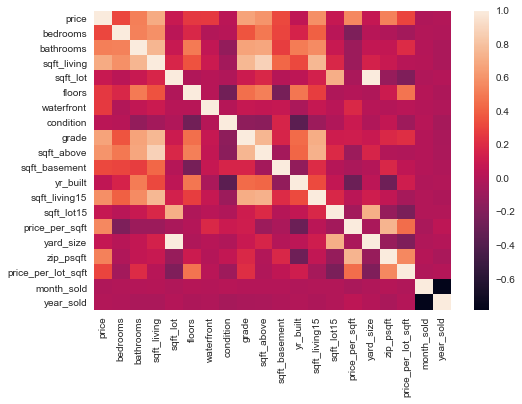

In [119]:
sns.heatmap(new_df)

In [120]:
# Table with highest correlations

best_corrs = new_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
best_corrs['pairs'] = list(zip(best_corrs.level_0, best_corrs.level_1))

# set index to pairs
best_corrs.set_index(['pairs'], inplace = True)

#d rop level columns
best_corrs.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
best_corrs.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
best_corrs.drop_duplicates(inplace=True)

In [121]:
best_corrs[best_corrs['cc']>.7]

,cc
pairs,
"(price, price)",1.000000
"(sqft_lot, yard_size)",0.999734
"(year_sold, month_sold)",0.971153
"(sqft_living, sqft_living15)",0.944902
"(sqft_lot, sqft_lot15)",0.943389
"(yard_size, sqft_lot15)",0.941982
"(sqft_living, sqft_above)",0.933948
"(sqft_living15, sqft_above)",0.931769
"(grade, sqft_above)",0.929654


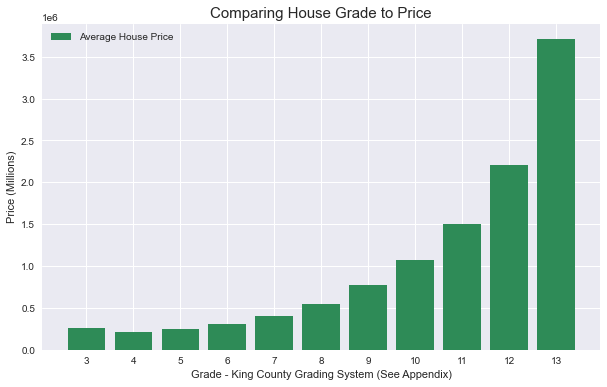

In [55]:
fig, ax = plt.subplots(figsize=(10,6))

grade_means = df.groupby('grade')['price'].mean().values

bar1 = [i for i in range(3,14)]

ax.bar(bar1, grade_means, width=.8, color='seagreen', label='Average House Price', align='center')

ax.set_xticks([i for i in range(3,14)])
ax.set_xlabel('Grade - King County Grading System (See Appendix)')
ax.set_ylabel('Price (Millions)')
ax.set_title('Comparing House Grade to Price', size=15)
ax.legend()

In [56]:
df['price'].mean()

540291.9567512502

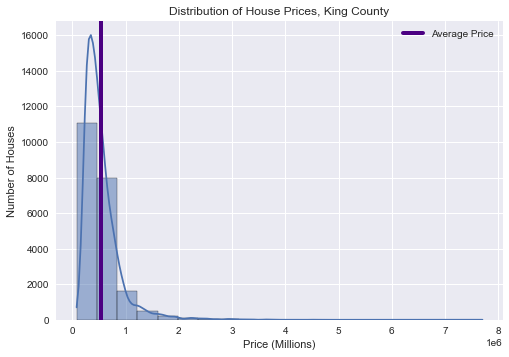

In [58]:
# Distribution of prices
sns.histplot(df['price'], bins=20, kde=True)
plt.title('Distribution of House Prices, King County')
plt.axvline(x=df['price'].mean(), ymin=0, ymax=6000, lw=4, color='indigo', label='Average Price')
plt.xlabel('Price (Millions)')
plt.ylabel('Number of Houses')
plt.legend()

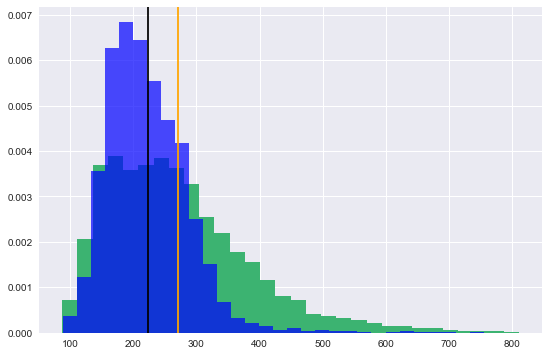

In [67]:
# comparing price distributions for uninc and inc areas
inc = df['price_per_sqft'][(df['unincorporated']=='N')]
uninc = df['price_per_sqft'][(df['unincorporated']=='Y')]

fig, ax = plt.subplots(figsize=(9,6))

ax.hist(inc, bins=30, color='mediumseagreen', density=True) # inc
ax.hist(uninc, bins=30, color='blue', density=True, alpha=.7) # not inc

ax.axvline(x=df['price_per_sqft'][(df['unincorporated']=='N')].mean(), color='orange') # incorporated
ax.axvline(x=df['price_per_sqft'][(df['unincorporated']=='Y')].mean(), color='black') # not inc

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

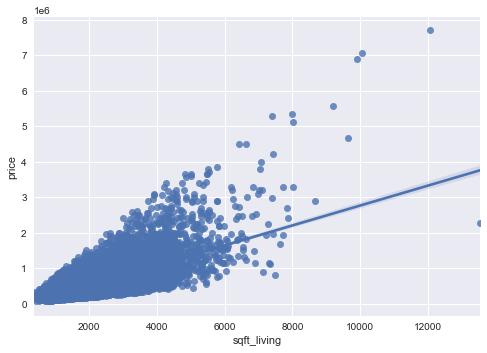

In [998]:
# Distribution of sqft_living and price
sns.regplot(x=df.sqft_living, y=df.price)

###### Distribution of prices - city vs out of city

[Source](https://stackoverflow.com/questions/44552489/plotting-multiple-boxplots-in-seaborn)

In [999]:
in_city = df[['price', 'in_city']][df['in_city']=='Y']
out_of_city = df[['price', 'in_city']][df['in_city']=='N']

cdf = pd.concat([in_city, out_of_city])  
cdf.head()# CONCATENATE
#mdf = pd.melt(cdf, id_vars=['price'], var_name=['in_city']) 
#mdf.head()# MELT

,price,in_city
0,221900.0,Y
1,538000.0,Y
3,604000.0,Y
7,291850.0,Y
8,229500.0,Y


<AxesSubplot:xlabel='in_city', ylabel='price'>

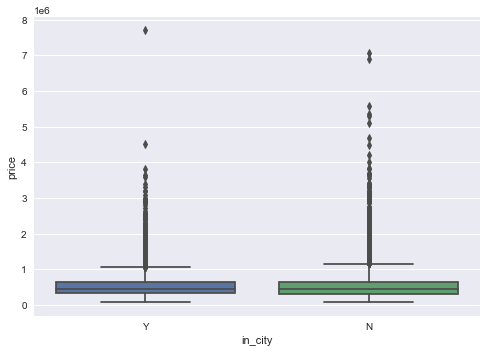

In [1000]:
sns.boxplot(x='in_city', y='price', data=cdf)

Text(0.5, 0, 'In City? Y or N')

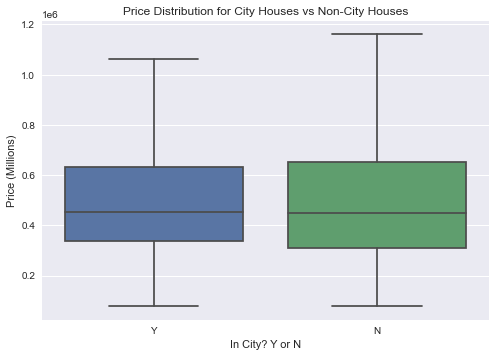

In [1001]:
sns.boxplot(x='in_city', y='price', data=cdf, showfliers=False)
plt.title('Price Distribution for City Houses vs Non-City Houses', size=15)  
plt.ylabel('Price (Millions)')
plt.xlabel('In City? Y or N')

###### Distribution of prices per grade

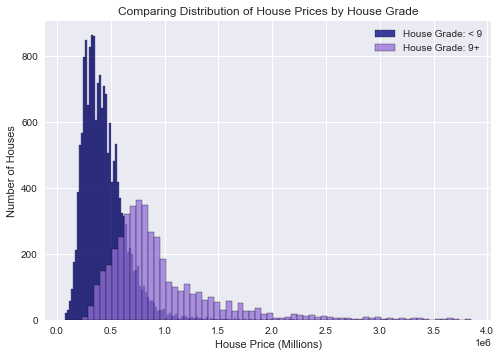

In [864]:
sns.histplot(df['price'][(df['grade']<9)&(df['price']<4000000)], color='navy', label='House Grade: < 9')
sns.histplot(df['price'][(df['grade']>=9)&(df['price']<4000000)], color='mediumpurple', label='House Grade: 9+')
plt.title('Comparing Distribution of House Prices by House Grade')
plt.xlabel('House Price (Millions)')
plt.ylabel('Number of Houses')
plt.legend()

###### Year built distribution

<AxesSubplot:xlabel='yr_built', ylabel='Count'>

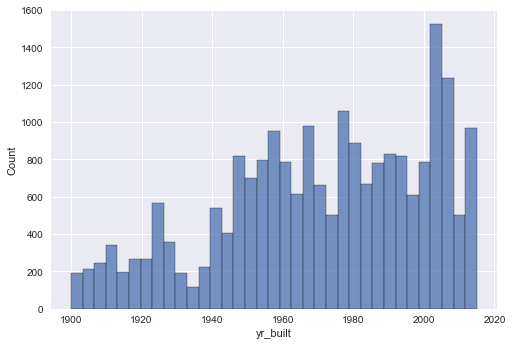

In [552]:
sns.histplot(df.yr_built)

<AxesSubplot:xlabel='zip_psqft', ylabel='Count'>

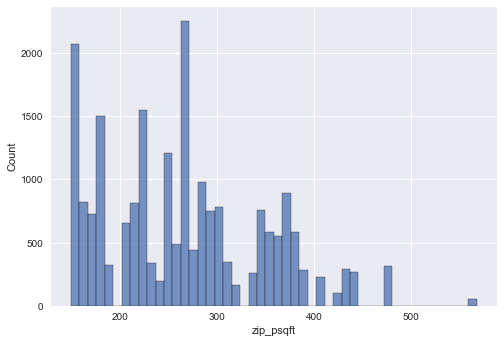

In [641]:
sns.histplot(df.zip_psqft)

###### Waterfront views? 

In [221]:
df_wf = df
df_wf.dropna(inplace=True, subset=['waterfront'])

In [222]:
df_wf.isna().sum()

id                   0
date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront           0
view                57
condition            0
grade                0
sqft_above           0
sqft_basement        0
yr_built             0
yr_renovated      3412
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
price_per_sqft       0
month_sold           0
unincorporated       0
dtype: int64

In [223]:
df_wf.waterfront.value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [224]:
df_wf['price'][df_wf['waterfront']==1.0].mean()

1717214.7260273972

In [225]:
df_wf['price'][df_wf['waterfront']==0.0].mean()

532641.9866841416

In [65]:
df.waterfront.value_counts()

0.000000    19074
0.007596     2376
1.000000      146
Name: waterfront, dtype: int64

In [ ]:
df

Text(0, 0.5, 'Density')

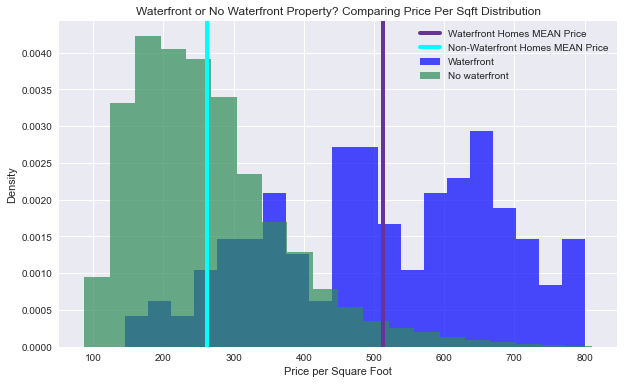

In [66]:
waterfront = df['price_per_sqft'][df['waterfront']==1]
no_waterfront = df['price_per_sqft'][df['waterfront']==0]
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(waterfront, bins=20, color='blue', density=True, alpha=.7, label='Waterfront')
ax.hist(no_waterfront, bins=20, color='seagreen', density=True, alpha=.7, label='No waterfront')
ax.axvline(df['price_per_sqft'][df['waterfront']==1].mean(), color='rebeccapurple', lw=4, label='Waterfront Homes MEAN Price')
ax.axvline(df['price_per_sqft'][df['waterfront']==0].mean(), color='cyan', lw=4, label='Non-Waterfront Homes MEAN Price')
ax.legend()
ax.set_title('Waterfront or No Waterfront Property? Comparing Price Per Sqft Distribution')
ax.set_xlabel('Price per Square Foot')
ax.set_ylabel('Density')

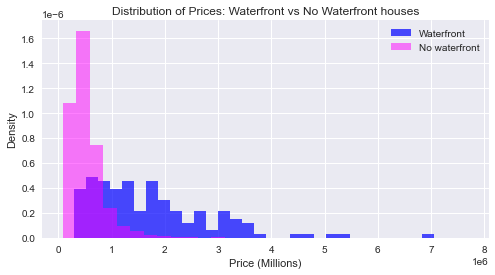

In [815]:
waterfront = df_wf['price'][df_wf['waterfront']==1]
no_waterfront = df_wf['price'][df_wf['waterfront']==0]
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(waterfront, bins=30, color='blue', density=True, alpha=.7, label='Waterfront')
ax.hist(no_waterfront, bins=30, color='magenta', density=True, alpha=.5, label='No waterfront')
ax.set_title('Distribution of Prices: Waterfront vs No Waterfront houses')
ax.set_xlabel('Price (Millions)')
ax.set_ylabel('Density')
ax.legend()

Text(0, 0.5, 'Average Price per Sqft')

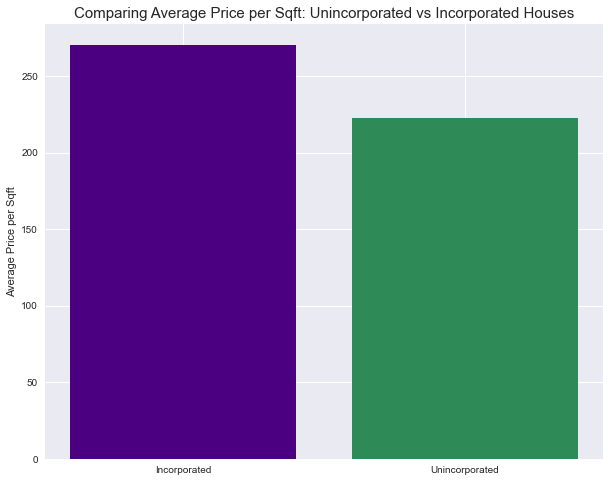

In [1111]:
# Measuring average price per sqft for uninc vs inc

fig, ax = plt.subplots(figsize=(10,8))

x = ['Incorporated', 'Unincorporated']
y = [df['price_per_sqft'][(df['unincorporated']=='N')].mean(), df['price_per_sqft'][(df['unincorporated']=='Y')].mean()]
ax.bar(x, y, color=['indigo', 'seagreen'])
ax.set_title('Comparing Average Price per Sqft: Unincorporated vs Incorporated Houses', size=15)
ax.set_ylabel('Average Price per Sqft')

### GeoPandas

In [841]:
import geopandas as gpd

In [842]:
kc = gpd.read_file('../src/shapefile/Zipcodes_for_King_County_and_Surrounding_Area_(Shorelines)___zipcode_shore_area.shp')

In [1028]:
kc.ZIP.value_counts()

98047    2
98354    2
98077    2
98022    2
98422    2
        ..
98467    1
98466    1
98465    1
98208    1
98304    1
Name: ZIP, Length: 197, dtype: int64

In [1011]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'price_per_sqft', 'in_city', 'yard_size', 'zip_psqft',
       'location_cost', 'price_per_lot_sqft', 'month_sold', 'season_sold',
       'year_sold', 'decade_built', '40yr_section', 'unincorporated'],
      dtype='object')

In [1037]:
zip_psqft_df = df[['zipcode', 'zip_psqft']].drop_duplicates()
data_zips = [zip_psqft_df.value_counts().index[i][0] for i in range(len(zip_psqft_df.value_counts().index))]

In [1038]:
data_zips[:5]

[98199, 98040, 98031, 98032, 98033]

In [1062]:
kc_all_zips = list(kc['ZIP'].value_counts().index)
kc_unique_zips = []
for i in range(len(kc_all_zips)):
    if kc_all_zips[i] not in data_zips:
        kc_unique_zips.append(kc_all_zips[i])
zeros = np.zeros((1, len(kc_unique_zips)))
other_zips = pd.DataFrame(np.reshape(np.array(kc_unique_zips), (1, len(kc_unique_zips)))).T
other_zips = pd.concat([other_zips, pd.DataFrame(zeros).T], axis=1)
other_zips.columns = ['zipcode', 'zip_psqft']
other_zips

,zipcode,zip_psqft
0,98047,0.0
1,98354,0.0
2,98422,0.0
3,98134,0.0
4,98388,0.0
...,...,...
122,98467,0.0
123,98466,0.0
124,98465,0.0
125,98208,0.0


In [1021]:
cloropleth_info = kc.merge(zip_psqft_df, left_on = 'ZIP', right_on = 'zipcode')

In [1064]:
cloropleth_allzips = pd.concat([cloropleth_info, other_zips])
cloropleth_allzips.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 201 entries, 0 to 126
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    74 non-null     float64 
 1   ZIP         74 non-null     float64 
 2   ZIPCODE     74 non-null     object  
 3   COUNTY      74 non-null     object  
 4   ZIP_TYPE    74 non-null     object  
 5   Shape_Leng  74 non-null     float64 
 6   Shape_Area  74 non-null     float64 
 7   geometry    74 non-null     geometry
 8   zipcode     201 non-null    int64   
 9   zip_psqft   201 non-null    float64 
dtypes: float64(5), geometry(1), int64(1), object(3)
memory usage: 17.3+ KB


In [1066]:
cloropleth_allzips['zip_psqft'][cloropleth_allzips['zip_psqft']==0]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
122    0.0
123    0.0
124    0.0
125    0.0
126    0.0
Name: zip_psqft, Length: 127, dtype: float64

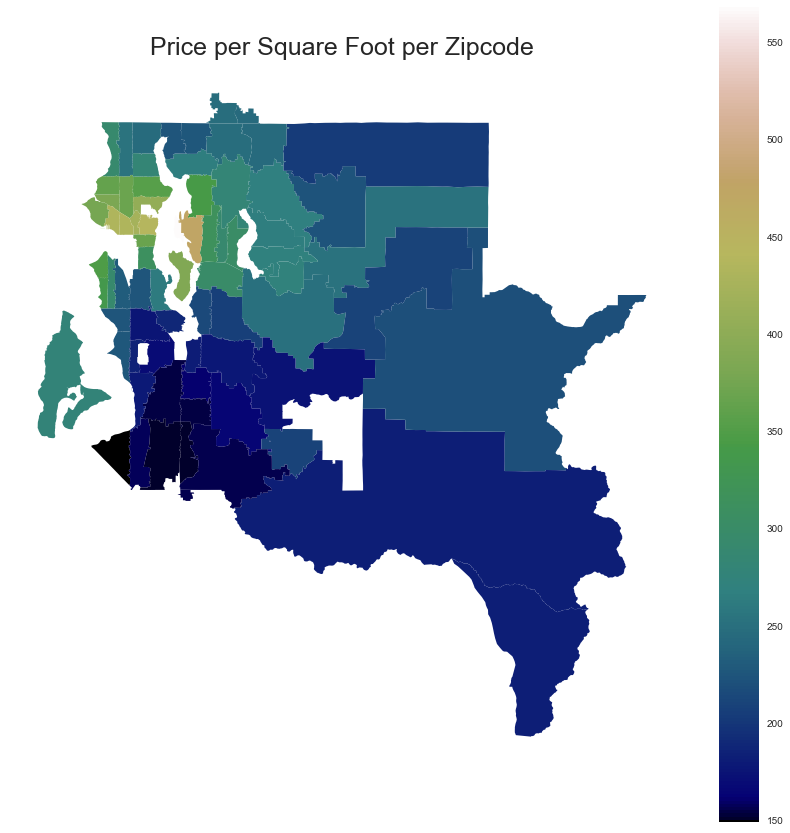

In [1088]:
fig, ax = plt.subplots(figsize=(15,15))
cloropleth_info.dropna().plot(column='zip_psqft',
                                   ax = ax,
                                   cmap = 'gist_earth',
                                   k=5, 
                                   legend = True);

ax.set_title('Price per Square Foot per Zipcode', fontdict= 
            {'fontsize':25})
#remove axes
ax.set_axis_off()
#move legend to an empty space
fig.savefig('priceperSQFT_cloropleth.png')

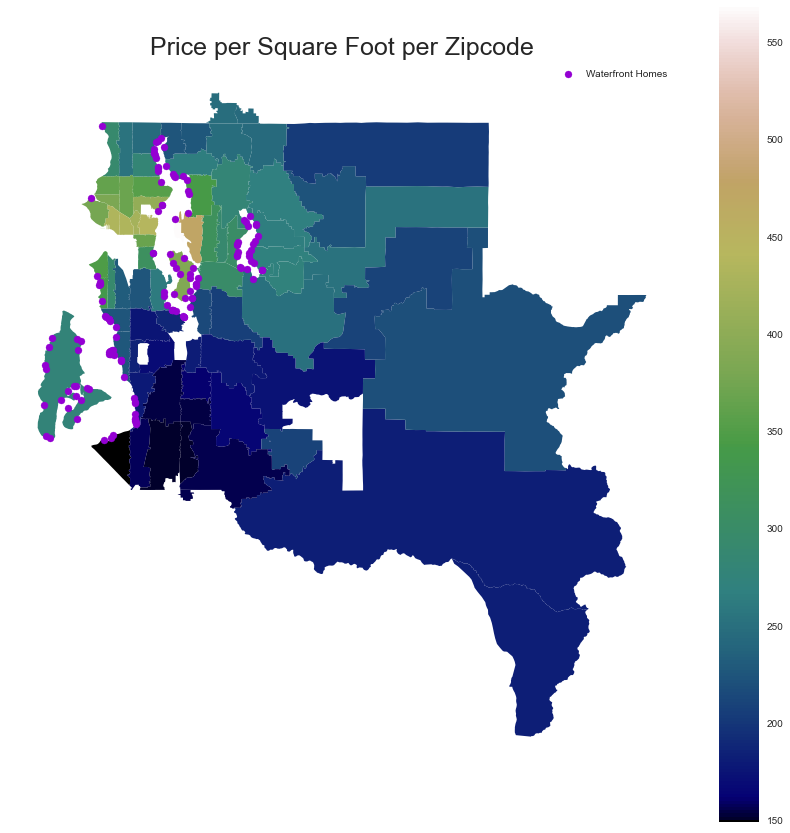

In [1091]:
fig, ax = plt.subplots(figsize=(15,15))
cloropleth_allzips.dropna().plot(column='zip_psqft',
                                   ax = ax,
                                   cmap = 'gist_earth',
                                   k=5, 
                                   legend = True);

ax.set_title('Price per Square Foot per Zipcode', fontdict= 
            {'fontsize':25})
#remove axes
ax.scatter(df['long'][df['waterfront']==1], df['lat'][df['waterfront']==1], color='darkviolet', label='Waterfront Homes')
ax.legend()
ax.set_axis_off()



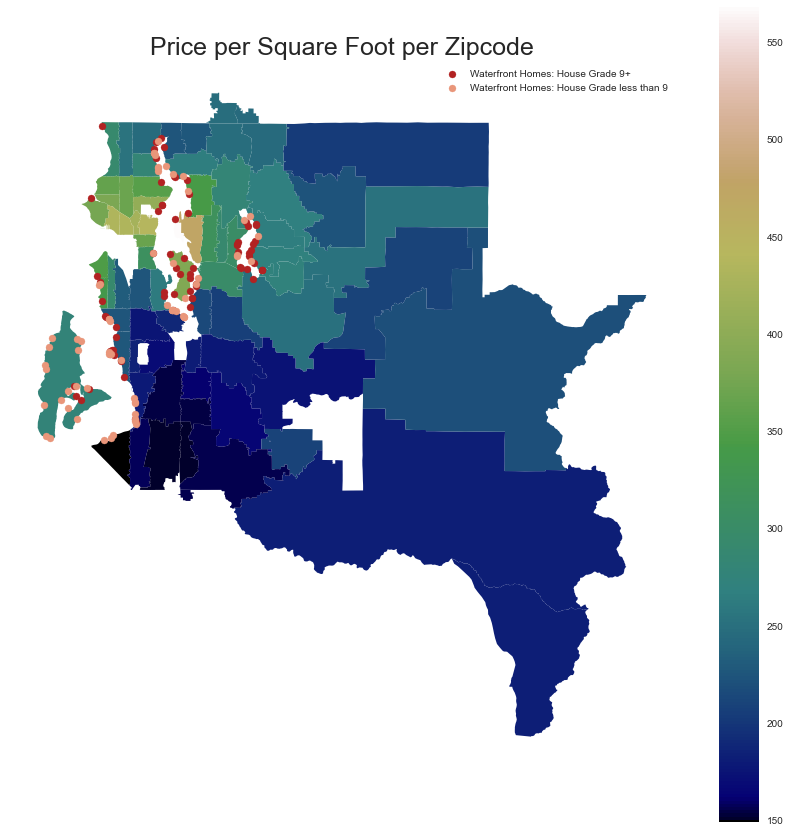

In [1094]:
fig, ax = plt.subplots(figsize=(15,15))
cloropleth_allzips.dropna().plot(column='zip_psqft',
                                   ax = ax,
                                   cmap = 'gist_earth',
                                   k=5, 
                                   legend = True);

ax.set_title('Price per Square Foot per Zipcode', fontdict= 
            {'fontsize':25})
#remove axes
ax.scatter(df['long'][(df['waterfront']==1)&(df['grade']>=9)], df['lat'][(df['waterfront']==1)&(df['grade']>=9)], color='firebrick', label='Waterfront Homes: House Grade 9+')
ax.scatter(df['long'][(df['waterfront']==1)&(df['grade']<9)], df['lat'][(df['waterfront']==1)&(df['grade']<9)], color='darksalmon', label='Waterfront Homes: House Grade less than 9')
ax.legend()
ax.set_axis_off()


In [1102]:
df['unincorporated'].value_counts()

N    18713
Y     2883
Name: unincorporated, dtype: int64

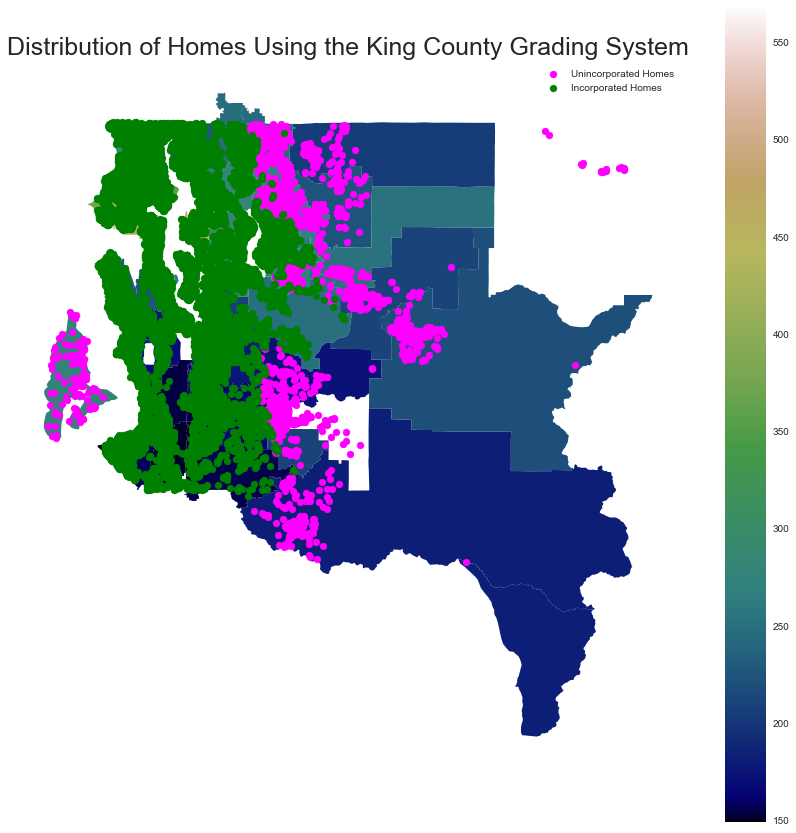

In [1104]:
fig, ax = plt.subplots(figsize=(15,15))
cloropleth_allzips.dropna().plot(column='zip_psqft',
                                   ax = ax,
                                   cmap = 'gist_earth',
                                   k=5, 
                                   legend = True);

ax.set_title('Distribution of Homes Using the King County Grading System', fontdict= 
            {'fontsize':25})
ax.scatter(df['long'][df['unincorporated']=='Y'], df['lat'][df['unincorporated']=='Y'], color='fuchsia', label='Unincorporated Homes')
ax.scatter(df['long'][df['unincorporated']=='N'], df['lat'][df['unincorporated']=='N'], color='green', label='Incorporated Homes')
ax.legend()
ax.set_axis_off()

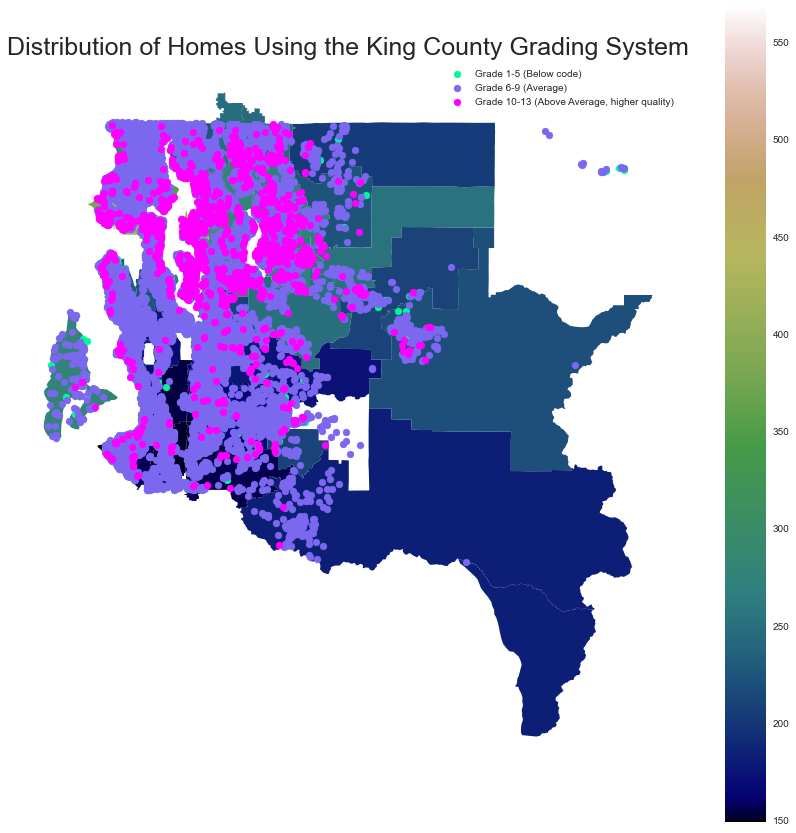

In [1100]:
fig, ax = plt.subplots(figsize=(15,15))
cloropleth_allzips.dropna().plot(column='zip_psqft',
                                   ax = ax,
                                   cmap = 'gist_earth',
                                   k=5, 
                                   legend = True);

ax.set_title('Distribution of Homes Using the King County Grading System', fontdict= 
            {'fontsize':25})
ax.set_axis_off()
ax.scatter(df['long'][df['grade']<6], df['lat'][df['grade']<6], color='mediumspringgreen', label='Grade 1-5 (Below code)')
ax.scatter(df['long'][(df['grade']>=6)&(df['grade']<10)], df['lat'][(df['grade']>=6)&(df['grade']<10)], color='mediumslateblue', label='Grade 6-9 (Average)')
ax.scatter(df['long'][df['grade']>=10], df['lat'][df['grade']>=10], color='fuchsia', label='Grade 10-13 (Above Average, higher quality)')
ax.legend()

Text(0.5, 1.0, 'Distribution of Houses - King County Housing Data')

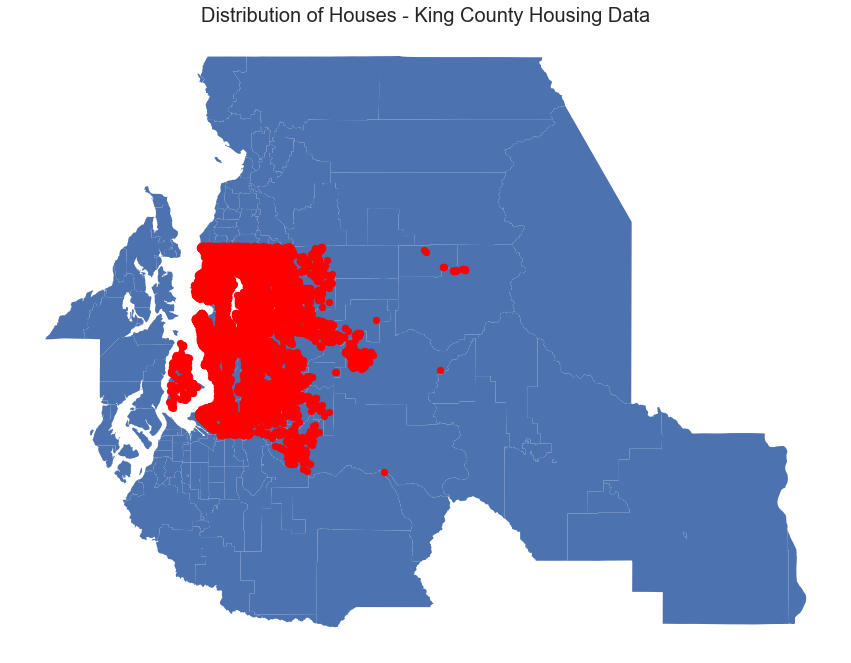

In [1087]:
fig, ax = plt.subplots(figsize=(15,15))
kc.plot(ax=ax)
ax.scatter(df['long'], df['lat'], color='red')
ax.set_axis_off()
ax.set_title('Distribution of Houses - King County Housing Data', size=20)

Text(0.5, 1.0, 'Distribution of Waterfront Homes - King County Housing Data')

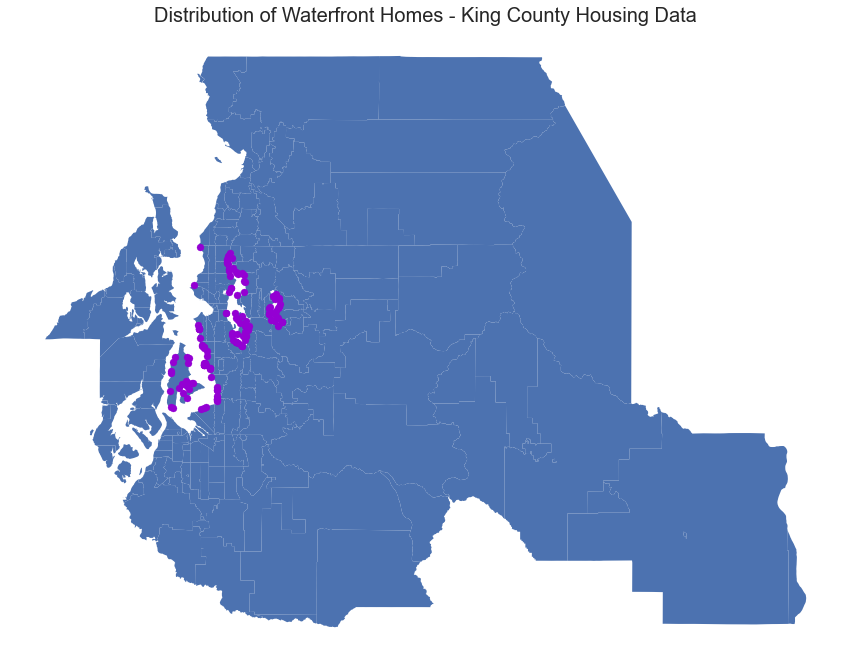

In [1089]:
fig, ax = plt.subplots(figsize=(15,15))
kc.plot(ax=ax)
ax.scatter(df['long'][df['waterfront']==1], df['lat'][df['waterfront']==1], color='darkviolet')
ax.set_axis_off()
ax.set_title('Distribution of Waterfront Homes - King County Housing Data', size=20)

Text(0.5, 1.0, 'Distribution of Homes Using the King County Grading System')

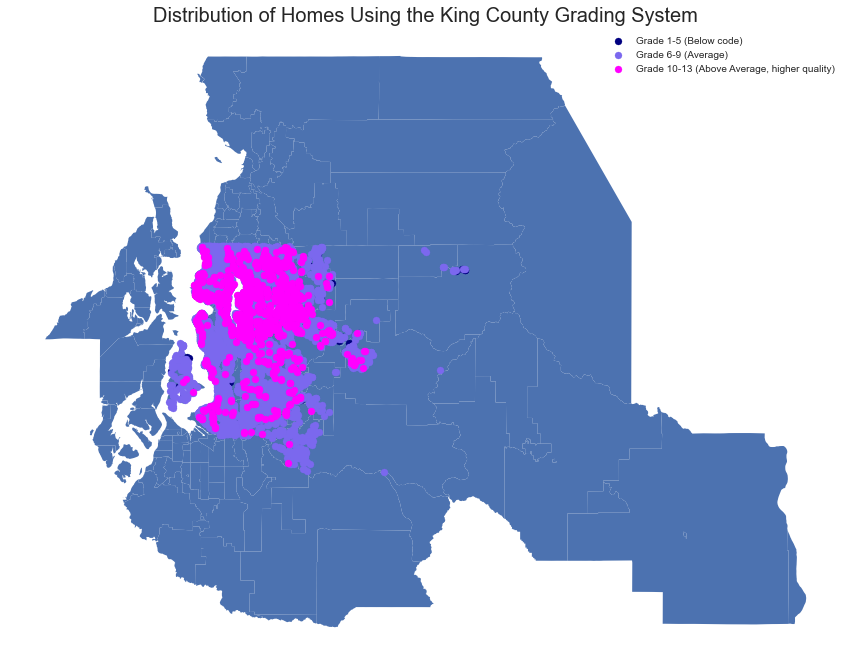

In [1097]:
fig, ax = plt.subplots(figsize=(15,15))
kc.plot(ax=ax)
ax.scatter(df['long'][df['grade']<6], df['lat'][df['grade']<6], color='navy', label='Grade 1-5 (Below code)')
ax.scatter(df['long'][(df['grade']>=6)&(df['grade']<10)], df['lat'][(df['grade']>=6)&(df['grade']<10)], color='mediumslateblue', label='Grade 6-9 (Average)')
ax.scatter(df['long'][df['grade']>=10], df['lat'][df['grade']>=10], color='fuchsia', label='Grade 10-13 (Above Average, higher quality)')
ax.legend()
ax.set_axis_off()
ax.set_title('Distribution of Homes Using the King County Grading System', size=20)

In [1004]:
df['location_cost'].value_counts()

zpsft200_300    10183
zpsft100_200     5440
zpsft300_400     4711
zpsft400_500     1212
zpsft500plus       50
Name: location_cost, dtype: int64

Text(0.5, 1.0, 'Distribution of Houses - Average Price per Square Foot by Zipcode')

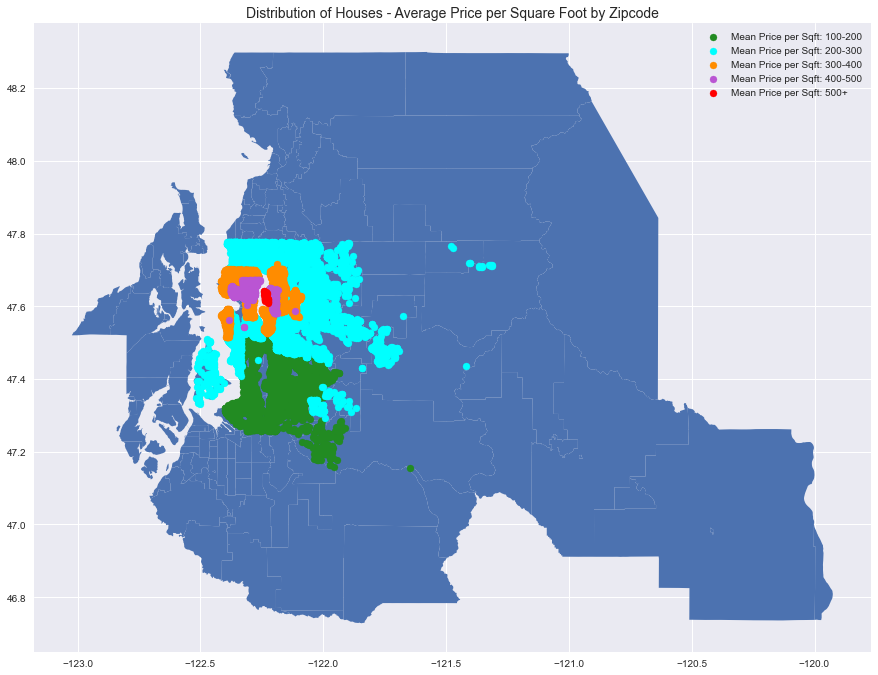

In [1008]:
# plotting areas in diff zip per sqft brackets

fig, ax = plt.subplots(figsize=(15,15))
kc.plot(ax=ax)

ax.scatter(df['long'][df['location_cost']=='zpsft100_200'], df['lat'][df['location_cost']=='zpsft100_200'], color='forestgreen', label='Mean Price per Sqft: 100-200')
ax.scatter(df['long'][df['location_cost']=='zpsft200_300'], df['lat'][df['location_cost']=='zpsft200_300'], color='cyan', label='Mean Price per Sqft: 200-300')
ax.scatter(df['long'][df['location_cost']=='zpsft300_400'], df['lat'][df['location_cost']=='zpsft300_400'], color='darkorange', label='Mean Price per Sqft: 300-400')
ax.scatter(df['long'][df['location_cost']=='zpsft400_500'], df['lat'][df['location_cost']=='zpsft400_500'], color='mediumorchid', label='Mean Price per Sqft: 400-500')
ax.scatter(df['long'][df['location_cost']=='zpsft500plus'], df['lat'][df['location_cost']=='zpsft500plus'], color='red', label='Mean Price per Sqft: 500+')
ax.legend()
ax.set_title('Distribution of Houses - Average Price per Square Foot by Zipcode', size=14)

Text(0.5, 1.0, 'Distribution of Houses - Price per Square Foot')

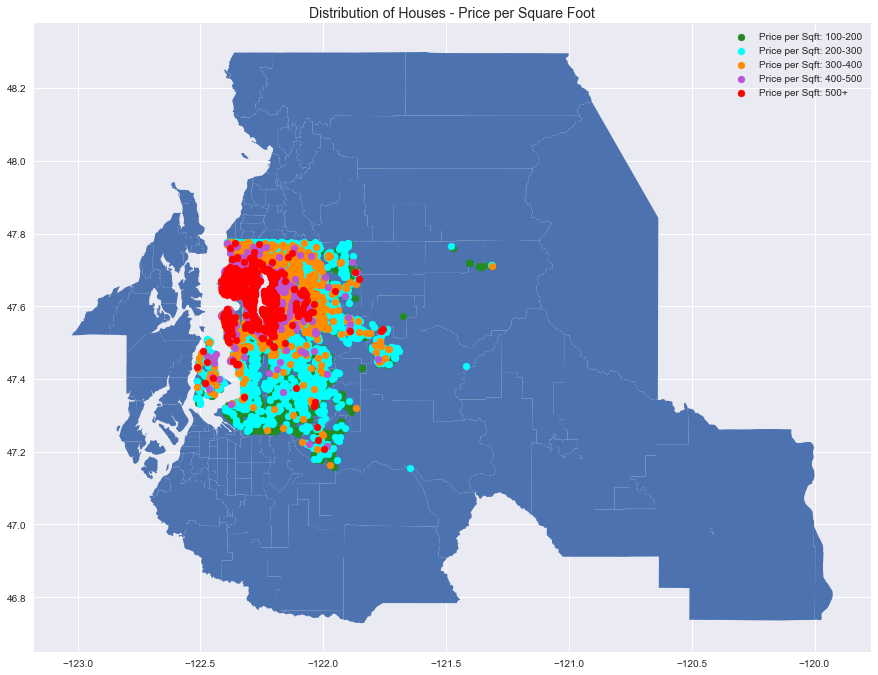

In [1009]:
fig, ax = plt.subplots(figsize=(15,15))
kc.plot(ax=ax)
ax.scatter(df['long'][df['price_per_sqft']<200], df['lat'][df['price_per_sqft']<200], color='forestgreen', label='Price per Sqft: 100-200')
ax.scatter(df['long'][(df['price_per_sqft']>=200)&(df['price_per_sqft']<300)], df['lat'][(df['price_per_sqft']>=200)&(df['price_per_sqft']<300)], color='cyan', label='Price per Sqft: 200-300')
ax.scatter(df['long'][(df['price_per_sqft']>=300)&(df['price_per_sqft']<400)], df['lat'][(df['price_per_sqft']>=300)&(df['price_per_sqft']<400)], color='darkorange', label='Price per Sqft: 300-400')
ax.scatter(df['long'][(df['price_per_sqft']>=400)&(df['price_per_sqft']<500)], df['lat'][(df['price_per_sqft']>=400)&(df['price_per_sqft']<500)], color='mediumorchid', label='Price per Sqft: 400-500')
ax.scatter(df['long'][df['price_per_sqft']>=500], df['lat'][df['price_per_sqft']>=500], color='red', label='Price per Sqft: 500+')
ax.legend()
ax.set_title('Distribution of Houses - Price per Square Foot', size=14)

## PreProcessing Data for Modeling 

In [122]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

##### DataFrame for Modeling

In [123]:
cols = df.drop(labels=['id', 'zipcode', 'lat', 'long', 'date'], axis=1).columns
mod_df = df[cols]

#### CATEGORICALS

###### bedrooms

In [124]:
bedroom_series = pd.Series(mod_df['bedrooms']).astype('category')

# Can concat to original data frame
bedrooms = pd.get_dummies(bedroom_series, prefix='bed', drop_first=True)
bedrooms.describe()

,bed_2,bed_3,bed_4,bed_5,bed_6,bed_7,bed_8,bed_9,bed_10,bed_11
count,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000
mean,0.127801,0.454899,0.318670,0.074134,0.012595,0.001760,0.000602,0.000278,0.000139,0.000046
std,0.333876,0.497973,0.465972,0.261995,0.111521,0.041911,0.024528,0.016666,0.011786,0.006805
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###### bathrooms

In [125]:
bathrooms_series = pd.Series(mod_df['bathrooms'])

cat_bathrooms = bathrooms_series.astype('category')

# Can concat to original data frame
bathrooms = pd.get_dummies(cat_bathrooms, prefix='bath', drop_first=True)

###### season sold (se)

In [126]:
seasons_series = pd.Series(df['season_sold'])

cat_seasons = seasons_series.astype('category')

# Can concat to original data frame
seasons = pd.get_dummies(cat_seasons, prefix='se', drop_first=True)
seasons.describe()

,se_spring,se_summer,se_winter
count,21596.000000,21596.000000,21596.000000
mean,0.301769,0.292971,0.171096
std,0.459036,0.455136,0.376602
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


###### waterfront (wf) 

In [127]:
wf_series = pd.Series(df['waterfront'])

cat_wf = wf_series.astype('category')

# Can concat to original data frame
wf = pd.get_dummies(cat_wf, prefix='wf', drop_first=True)
wf.describe()

,wf_0.007595858696217679,wf_1.0
count,21596.000000,21596.000000
mean,0.110020,0.006761
std,0.312922,0.081946
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


###### grade

In [128]:
grade_series = pd.Series(df['grade']).astype('category')

# Can concat to original data frame
grade = pd.get_dummies(grade_series, prefix='gr', drop_first=True)
grade.describe()

,gr_4,gr_5,gr_6,gr_7,gr_8,gr_9,gr_10,gr_11,gr_12,gr_13
count,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000
mean,0.001250,0.011206,0.094369,0.415494,0.280839,0.121087,0.052510,0.018476,0.004121,0.000602
std,0.035337,0.105265,0.292349,0.492818,0.449419,0.326236,0.223058,0.134667,0.064065,0.024528
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###### in_city

In [129]:
in_city_series = pd.Series(df['in_city']).astype('category')

# Can concat to original data frame
in_city = pd.get_dummies(in_city_series, prefix='incity', drop_first=True)
in_city.describe()

,incity_Y
count,21596.000000
mean,0.415447
std,0.492810
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


###### yr_built

In [130]:
yrbuilt_series = pd.Series(df['yr_built']).astype('category')

# Can concat to original data frame
yrbuilt = pd.get_dummies(yrbuilt_series, prefix='yrb', drop_first=True)
yrbuilt.describe()

,yrb_1901,yrb_1902,yrb_1903,yrb_1904,yrb_1905,yrb_1906,yrb_1907,yrb_1908,yrb_1909,yrb_1910,...,yrb_2006,yrb_2007,yrb_2008,yrb_2009,yrb_2010,yrb_2011,yrb_2012,yrb_2013,yrb_2014,yrb_2015
count,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.00000,21596.000000,21596.000000,21596.000000,...,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000
mean,0.001343,0.001250,0.002130,0.002084,0.003427,0.004260,0.00301,0.003982,0.004353,0.006205,...,0.020976,0.019309,0.016994,0.010650,0.006622,0.006020,0.007872,0.009307,0.025884,0.001760
std,0.036621,0.035337,0.046104,0.045601,0.058438,0.065131,0.05478,0.062981,0.065832,0.078528,...,0.143308,0.137612,0.129251,0.102651,0.081105,0.077354,0.088375,0.096026,0.158794,0.041911
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###### decade_built

In [131]:
decade_series = pd.Series(df['decade_built']).astype('category')

decades = pd.get_dummies(decade_series, prefix='decb', drop_first=True)
decades.describe()

,decb_1910_1920,decb_1920_1930,decb_1930_1940,decb_1940_1950,decb_1950_1960,decb_1960_1970,decb_1970_1980,decb_1980_1990,decb_1990_2000,decb_2000_2010,decb_2010_2020
count,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000
mean,0.037275,0.055195,0.024542,0.081589,0.113447,0.123078,0.105807,0.105621,0.103352,0.162762,0.057464
std,0.189440,0.228367,0.154727,0.273744,0.317146,0.328535,0.307597,0.307360,0.304426,0.369157,0.232733
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###### 40yr_section

In [132]:
fortyyr_series = pd.Series(df['40yr_section']).astype('category')

# Can concat to original data frame
fortyyr = pd.get_dummies(fortyyr_series, prefix='fortyyr', drop_first=True)
fortyyr.describe()

,fortyyr_1940_1980,fortyyr_1980_2020
count,21596.000000,21596.000000
mean,0.423921,0.429154
std,0.494190,0.494967
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


######  month sold (mo)

In [133]:
months_series = pd.Series(df['month_sold'])

cat_months = months_series.astype('category')

# Can concat to original data frame
months = pd.get_dummies(cat_months, prefix='mo', drop_first=True)
months.describe()

,mo_2,mo_3,mo_4,mo_5,mo_6,mo_7,mo_8,mo_9,mo_10,mo_11,mo_12
count,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000
mean,0.057742,0.086822,0.103214,0.111780,0.100806,0.102380,0.089785,0.082006,0.086868,0.065244,0.068068
std,0.233261,0.281580,0.304245,0.315103,0.301078,0.303154,0.285880,0.274380,0.281648,0.246961,0.251869
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###### floors

In [134]:
floor_series = pd.Series(df['floors']).astype('category')

# Can concat to original data frame
floors = pd.get_dummies(floor_series, prefix='flr', drop_first=True)
floors.describe()

,flr_1.5,flr_2.0,flr_2.5,flr_3.0,flr_3.5
count,21596.000000,21596.000000,21596.000000,21596.000000,21596.000000
mean,0.088442,0.381321,0.007455,0.028292,0.000324
std,0.283944,0.485722,0.086022,0.165810,0.018001
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


###### condition

In [135]:
condition_series = pd.Series(df['condition']).astype('category')

# Can concat to original data frame
conditions = pd.get_dummies(condition_series, prefix='cond', drop_first=True)
conditions.describe()

,cond_2,cond_3,cond_4,cond_5
count,21596.000000,21596.000000,21596.000000,21596.000000
mean,0.007872,0.649194,0.262873,0.078718
std,0.088375,0.477233,0.440204,0.269305
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


###### location cost

In [136]:
df['location_cost']

0        zpsft100_200
1        zpsft200_300
2        zpsft200_300
3        zpsft300_400
4        zpsft200_300
             ...     
21592    zpsft300_400
21593    zpsft200_300
21594    zpsft300_400
21595    zpsft200_300
21596    zpsft300_400
Name: location_cost, Length: 21596, dtype: object

In [137]:
lc_series = pd.Series(df['location_cost']).astype('category')

lc = pd.get_dummies(lc_series, drop_first=True)

###### unincorporated (inc)

In [138]:
inc_series = pd.Series(df['unincorporated']).astype('category')

# Can concat to original data frame
inc = pd.get_dummies(inc_series, prefix='inc', drop_first=True)
inc.head()

,inc_Y
0,0
1,0
2,0
3,0
4,0


#### Join categoricals to mod_df

In [139]:
mod_df.location_cost.value_counts()

zpsft200_300    10183
zpsft100_200     5440
zpsft300_400     4711
zpsft400_500     1212
zpsft500plus       50
Name: location_cost, dtype: int64

In [140]:
mod_df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'sqft_living15', 'sqft_lot15', 'price_per_sqft', 'in_city',
       'yard_size', 'zip_psqft', 'location_cost', 'price_per_lot_sqft',
       'month_sold', 'season_sold', 'year_sold', 'decade_built',
       '40yr_section', 'unincorporated'],
      dtype='object')

In [141]:
continuous = mod_df[['price', 'sqft_living', 'sqft_lot', 'sqft_above', 
                     'sqft_living15', 'sqft_lot15', 'price_per_sqft',
                    'zip_psqft', 'price_per_lot_sqft']]

In [142]:
mod_df = pd.concat([continuous, bedrooms, bathrooms, seasons, wf, grade, in_city, yrbuilt,
                    decades, fortyyr, months, floors, conditions, lc, inc], axis=1)

In [143]:
mod_df.head()

,price,sqft_living,sqft_lot,sqft_above,sqft_living15,sqft_lot15,price_per_sqft,zip_psqft,price_per_lot_sqft,bed_2,...,flr_3.5,cond_2,cond_3,cond_4,cond_5,zpsft200_300,zpsft300_400,zpsft400_500,zpsft500plus,inc_Y
0,221900.0,1180,5650,1180,1340,5650,188.050847,189.172528,39.274336,0,...,0,0,1,0,0,0,0,0,0,0
1,538000.0,2570,7242,2170,1690,7639,209.338521,282.680191,74.288870,0,...,0,0,1,0,0,1,0,0,0,0
2,180000.0,770,10000,770,2720,8062,233.766234,225.145368,18.000000,1,...,0,0,1,0,0,1,0,0,0,0
3,604000.0,1960,5000,1050,1360,5000,308.163265,337.245108,120.800000,0,...,0,0,0,0,1,0,1,0,0,0
4,510000.0,1680,8080,1680,1800,7503,303.571429,265.686627,63.118812,0,...,0,0,1,0,0,1,0,0,0,0


###### Stepwise selection function

In [144]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if (worst_pval > threshold_out) & (len(included)>0):
            changed=True
            worst_feature = pvalues.argmax()
            if worst_feature in included:
                included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

###### Optimizes R-squared value

In [767]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [145]:
X = mod_df.drop(labels='price', axis=1)

In [146]:
Y = mod_df.price

In [147]:
xcols = list(mod_df.drop(labels='price', axis=1).columns)

In [148]:
from statsmodels.graphics.gofplots import qqplot

### MODEL NUMERO UNO

In [776]:
len(Y)

21597

In [150]:
model = sm.OLS(Y.astype(float), sm.add_constant(X.astype(float))).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     1131.
Date:                Fri, 19 Feb 2021   Prob (F-statistic):               0.00
Time:                        04:04:01   Log-Likelihood:            -2.8074e+05
No. Observations:               21596   AIC:                         5.619e+05
Df Residuals:                   21391   BIC:                         5.635e+05
Df Model:                         204                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -6.968e+05   1.24e+05     -5.613      0.000    -9.4e+05   -4.54e+05
sqft_living               263.3466      2.618    100.602      0.000     258.216     268.478
sqft_lot                   -0.0454      0.026     -1.747      0.081      -0.096       0.006
sqft_above                 -5.3754      2.605     -2.064      0.039     -10.480      -0.270
sqft_living15             -10.6266      1.951     -5.447      0.000     -14.450      -6.803
sqft_lot15                 -0.2048      0.040     -5.125      0.000      -0.283      -0.126
price_per_sqft           1831.0523     13.042    140.402      0.000    1805.490    1856.615
zip_psqft                 204.8053     34.588      5.921      0.000     137.010     272.600
price_per_lot_sqft        148.6590     14.823     10.029      0.000     119.605     177.713
bed_2                    7.475e+04   8354.977      8.947      0.000    5.84e+04    9.11e+04
bed_3                    1.211e+05   8405.596     14.407      0.000    1.05e+05    1.38e+05
bed_4                    1.112e+05   8595.970     12.942      0.000    9.44e+04    1.28e+05
bed_5                    1.005e+05   9054.742     11.099      0.000    8.28e+04    1.18e+05
bed_6                    6.766e+04    1.1e+04      6.136      0.000     4.6e+04    8.93e+04
bed_7                   -2.313e+04   2.01e+04     -1.151      0.250   -6.25e+04    1.62e+04
bed_8                    8.273e+04   3.18e+04      2.602      0.009    2.04e+04    1.45e+05
bed_9                   -1.336e+04   4.99e+04     -0.268      0.789   -1.11e+05    8.44e+04
bed_10                  -5.535e+04   6.39e+04     -0.866      0.387   -1.81e+05       7e+04
bed_11                   5.835e+04   1.08e+05      0.538      0.591   -1.54e+05    2.71e+05
bath_0.75               -1.523e+05   5.57e+04     -2.736      0.006   -2.61e+05   -4.32e+04
bath_1.0                -8.915e+04   5.41e+04     -1.649      0.099   -1.95e+05    1.68e+04
bath_1.25               -1.498e+05    6.5e+04     -2.306      0.021   -2.77e+05   -2.25e+04
bath_1.5                -6.791e+04   5.41e+04     -1.254      0.210   -1.74e+05    3.82e+04
bath_1.75               -6.639e+04   5.41e+04     -1.227      0.220   -1.72e+05    3.97e+04
bath_2.0                 -5.99e+04   5.41e+04     -1.107      0.268   -1.66e+05    4.62e+04
bath_2.25               -5.827e+04   5.42e+04     -1.076      0.282   -1.64e+05    4.79e+04
bath_2.5                -6.259e+04   5.41e+04     -1.156      0.248   -1.69e+05    4.35e+04
bath_2.75               -6.987e+04   5.42e+04     -1.289      0.197   -1.76e+05    3.64e+04
bath_3.0                -6.034e+04   5.43e+04     -1.112      0.266   -1.67e+05     4.6e+04
bath_3.25                -4.55e+04   5.43e+04     -0.837      0.402   -1.52e+05     6.1e+04
bath_3.5                -7.204e+04   5.43e+04  

In [151]:
pvalues = model.pvalues.iloc[1:]
lowp_features = []
for i in range(len(pvalues)):
    if pvalues.sort_values().values[i] < 0.05:
        lowp_features.append(pvalues.sort_values().index[i])

In [159]:
lowp_features

['sqft_living',
 'price_per_sqft',
 'wf_1.0',
 'zpsft500plus',
 'bath_7.75',
 'bed_3',
 'bed_4',
 'bed_5',
 'price_per_lot_sqft',
 'gr_13',
 'bed_2',
 'bath_8.0',
 'zpsft200_300',
 'flr_2.5',
 'zpsft300_400',
 'bed_6',
 'zip_psqft',
 'bath_6.0',
 'sqft_living15',
 'incity_Y',
 'gr_12',
 'sqft_lot15',
 'decb_1960_1970',
 'flr_3.0',
 'decb_1950_1960',
 'decb_1930_1940',
 'decb_1970_1980',
 'bath_6.5',
 'decb_1940_1950',
 'decb_1980_1990',
 'yrb_2006',
 'yrb_1969',
 'yrb_1924',
 'yrb_1957',
 'yrb_1940',
 'gr_11',
 'bath_0.75',
 'mo_3',
 'mo_8',
 'bath_4.75',
 'bed_8',
 'yrb_1990',
 'yrb_2013',
 'yrb_1958',
 'yrb_1980',
 'bath_5.5',
 'mo_6',
 'flr_1.5',
 'decb_1910_1920',
 'bath_1.25',
 'yrb_1982',
 'se_winter',
 'zpsft400_500',
 'mo_7',
 'yrb_2009',
 'yrb_1983',
 'yrb_1981',
 'mo_4',
 'sqft_above',
 'yrb_1949',
 'yrb_1959',
 'yrb_1998',
 'yrb_1945',
 'yrb_2008']

In [153]:
lowp_X = X[lowp_features]
model_lowp = sm.OLS(Y.astype(float), sm.add_constant(lowp_X.astype(float))).fit()
model_lowp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     3456.
Date:                Fri, 19 Feb 2021   Prob (F-statistic):               0.00
Time:                        04:04:10   Log-Likelihood:            -2.8122e+05
No. Observations:               21596   AIC:                         5.626e+05
Df Residuals:                   21531   BIC:                         5.631e+05
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -6.914e+05   9491.932    -72.838      0.000    -7.1e+05   -6.73e+05
sqft_living          278.6245      2.242    124.269      0.000     274.230     283.019
price_per_sqft      1882.3441     12.371    152.159      0.000    1858.096    1906.592
wf_1.0              3.459e+05   9742.607     35.502      0.000    3.27e+05    3.65e+05
zpsft500plus        3.278e+05   2.04e+04     16.056      0.000    2.88e+05    3.68e+05
bath_7.75           2.064e+06   1.16e+05     17.846      0.000    1.84e+06    2.29e+06
bed_3               1.204e+05   7362.002     16.353      0.000    1.06e+05    1.35e+05
bed_4               1.088e+05   7492.908     14.520      0.000    9.41e+04    1.23e+05
bed_5                9.76e+04   7966.826     12.251      0.000     8.2e+04    1.13e+05
price_per_lot_sqft   150.9547     13.112     11.513      0.000     125.254     176.655
gr_13               9.537e+05   3.35e+04     28.457      0.000    8.88e+05    1.02e+06
bed_2               7.374e+04   7499.574      9.832      0.000     5.9e+04    8.84e+04
bath_8.0            6.108e+05   8.06e+04      7.582      0.000    4.53e+05    7.69e+05
zpsft200_300       -2.879e+04   3313.904     -8.688      0.000   -3.53e+04   -2.23e+04
flr_2.5             6.447e+04   8884.105      7.257      0.000    4.71e+04    8.19e+04
zpsft300_400       -4.744e+04   6369.486     -7.448      0.000   -5.99e+04    -3.5e+04
bed_6               6.839e+04   1.01e+04      6.785      0.000    4.86e+04    8.81e+04
zip_psqft            214.2592     34.784      6.160      0.000     146.080     282.438
bath_6.0             3.93e+05   4.63e+04      8.490      0.000    3.02e+05    4.84e+05
sqft_living15         -8.0741      1.882     -4.290      0.000     -11.763      -4.385
incity_Y           -1.197e+04   2146.820     -5.575      0.000   -1.62e+04   -7760.638
gr_12               4.033e+05   1.26e+04     31.906      0.000    3.79e+05    4.28e+05
sqft_lot15            -0.2391      0.029     -8.141      0.000      -0.297      -0.182
decb_1960_1970      3.259e+04   2899.182     11.241      0.000    2.69e+04    3.83e+04
flr_3.0            -3.003e+04   5369.730     -5.592      0.000   -4.06e+04   -1.95e+04
decb_1950_1960      2.708e+04   3294.484      8.220      0.000    2.06e+04    3.35e+04
decb_1930_1940      3.874e+04   5119.412      7.567      0.000    2.87e+04    4.88e+04
decb_1970_1980      2.568e+04   2938.827      8.737      0.000    1.99e+04    3.14e+04
bath_6.5           -3.231e+05    7.8e+04     -4.141      0.000   -4.76e+05    -1.7e+05
decb_1940_1950      2.479e+04   3655.233      6.781      0.000    1.76e+04    3.19e+04
decb_1980_1990      1.659e+04   3232.784      5.133      0.000    1.03e+04    2.29e+04
yrb_2006           -2.229e+04   5372.167     -4.149      0.000   -3.28e+04   -1.18e+04
yrb_1969            1.915e+04   6941.7

In [155]:
Y_norm = Y.map(lambda x: np.log(x))

In [6]:
lowp_features[:10]

NameError: name 'lowp_features' is not defined

In [158]:
lowp_top5 = X[lowp_features[:5]]
model_lowpt5 = sm.OLS(Y_norm.astype(float), sm.add_constant(lowp_top5.astype(float))).fit()
model_lowpt5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                 4.223e+04
Date:                Fri, 19 Feb 2021   Prob (F-statistic):               0.00
Time:                        04:05:45   Log-Likelihood:                 8883.2
No. Observations:               21596   AIC:                        -1.775e+04
Df Residuals:                   21590   BIC:                        -1.771e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             11.3026      0.004   2787.984      0.000      11.295      11.311
sqft_living        0.0004   1.21e-06    360.999      0.000       0.000       0.000
price_per_sqft     0.0032   1.03e-05    308.696      0.000       0.003       0.003
wf_1.0            -0.2094      0.014    -15.317      0.000      -0.236      -0.183
zpsft500plus      -0.2561      0.023    -11.014      0.000      -0.302      -0.211
bath_7.75         -1.8359      0.162    -11.318      0.000      -2.154      -1.518
==============================================================================
Omnibus:                    12031.045   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           263962.205
Skew:                          -2.230   Prob(JB):                         0.00
Kurtosis:                      19.537   Cond. No.                     3.40e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [161]:
lowp_top5 = X[trial2]
model_lowpt5 = sm.OLS(Y_norm.astype(float), sm.add_constant(lowp_top5.astype(float))).fit()
model_lowpt5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     3708.
Date:                Fri, 19 Feb 2021   Prob (F-statistic):               0.00
Time:                        04:09:46   Log-Likelihood:                -8266.4
No. Observations:               21596   AIC:                         1.655e+04
Df Residuals:                   21588   BIC:                         1.661e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             11.8046      0.010   1209.976      0.000      11.785      11.824
price_per_sqft     0.0032   2.33e-05    136.929      0.000       0.003       0.003
wf_1.0             0.3191      0.030     10.629      0.000       0.260       0.378
zpsft500plus       0.2587      0.051      5.042      0.000       0.158       0.359
bath_7.75          1.4585      0.359      4.068      0.000       0.756       2.161
bed_3              0.2999      0.007     41.024      0.000       0.286       0.314
bed_4              0.6363      0.008     81.957      0.000       0.621       0.651
bed_5              0.7890      0.011     71.846      0.000       0.767       0.811
==============================================================================
Omnibus:                      734.663   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1008.807
Skew:                           0.363   Prob(JB):                    8.72e-220
Kurtosis:                       3.770   Cond. No.                     4.25e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [831]:
high_corrs = X.corr().abs().stack().reset_index().sort_values(0, ascending=False)
high_corrs.columns = ['feat1', 'feat2', 'cc']
high_corrs[(high_corrs['cc']>=.7)&(high_corrs['cc']<1)]
corr_list = ['sqft_above', 'cond_3', 'sqft_living15', 'price_per_sqft', 'fortyyr_1940_1980', 'sqft_lot15']

### Model NUMERO DOS - NORMALIZING PRICE ONLY

In [805]:
Y_norm = Y.map(lambda x: np.log(x))

In [806]:
model = sm.OLS(Y_norm.astype(float), sm.add_constant(X.astype(float))).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     2367.
Date:                Wed, 17 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:32:31   Log-Likelihood:                 72839.
No. Observations:               21597   AIC:                        -1.453e+05
Df Residuals:                   21394   BIC:                        -1.437e+05
Df Model:                         202                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       2.0129      0.008    247.276      0.000       1.997       2.029
sqft_living              2.675e-05   2.03e-07    131.771      0.000    2.63e-05    2.71e-05
sqft_lot                 1.698e-08   2.01e-09      8.429      0.000     1.3e-08    2.09e-08
sqft_above               4.417e-07   2.02e-07      2.187      0.029    4.58e-08    8.38e-07
sqft_living15            1.947e-06   1.51e-07     12.869      0.000    1.65e-06    2.24e-06
sqft_lot15               3.229e-09    3.1e-09      1.042      0.297   -2.84e-09     9.3e-09
price_per_sqft              0.0002   1.01e-06    200.512      0.000       0.000       0.000
zip_psqft                7.717e-05   2.68e-06     28.776      0.000    7.19e-05    8.24e-05
price_per_lot_sqft       5.818e-06   1.15e-06      5.062      0.000    3.57e-06    8.07e-06
bed_2                       0.0107      0.001     16.544      0.000       0.009       0.012
bed_3                       0.0163      0.001     24.980      0.000       0.015       0.018
bed_4                       0.0172      0.001     25.798      0.000       0.016       0.019
bed_5                       0.0151      0.001     21.445      0.000       0.014       0.016
bed_6                       0.0144      0.001     16.825      0.000       0.013       0.016
bed_7                       0.0118      0.002      7.597      0.000       0.009       0.015
bed_8                       0.0122      0.002      4.956      0.000       0.007       0.017
bed_9                       0.0228      0.004      5.894      0.000       0.015       0.030
bed_10                      0.0178      0.005      3.584      0.000       0.008       0.027
bed_11                      0.0205      0.008      2.437      0.015       0.004       0.037
bed_33                      0.0169      0.008      2.012      0.044       0.000       0.033
bath_0.75                  -0.0002      0.004     -0.053      0.958      -0.009       0.008
bath_1.0                    0.0030      0.004      0.721      0.471      -0.005       0.011
bath_1.25                   0.0082      0.005      1.632      0.103      -0.002       0.018
bath_1.5                    0.0081      0.004      1.921      0.055      -0.000       0.016
bath_1.75                   0.0115      0.004      2.737      0.006       0.003       0.020
bath_2.0                    0.0114      0.004      2.725      0.006       0.003       0.020
bath_2.25                   0.0124      0.004      2.963      0.003       0.004       0.021
bath_2.5                    0.0132      0.004      3.144      0.002       0.005       0.021
bath_2.75                   0.0130      0.004      3.095      0.002       0.005       0.021
bath_3.0                    0.0121      0.004      2.870      0.004       0.004       0.020
bath_3.25                   0.0099      0.004  

In [833]:
X_nohcorrs = X.drop(labels=corr_list, axis=1)
modelnhc = sm.OLS(Y_norm.astype(float), sm.add_constant(X_nohcorrs.astype(float))).fit()
modelnhc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     717.2
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:13:24   Log-Likelihood:                 60675.
No. Observations:               21597   AIC:                        -1.210e+05
Df Residuals:                   21400   BIC:                        -1.194e+05
Df Model:                         196                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       2.0658      0.014    146.528      0.000       2.038       2.093
sqft_living              1.785e-05   2.45e-07     72.837      0.000    1.74e-05    1.83e-05
sqft_lot                 5.597e-08   2.62e-09     21.346      0.000    5.08e-08    6.11e-08
zip_psqft                   0.0003   4.46e-06     57.221      0.000       0.000       0.000
price_per_lot_sqft       3.647e-05   1.92e-06     19.039      0.000    3.27e-05    4.02e-05
bed_2                       0.0010      0.001      0.871      0.384      -0.001       0.003
bed_3                       0.0031      0.001      2.739      0.006       0.001       0.005
bed_4                       0.0035      0.001      2.980      0.003       0.001       0.006
bed_5                       0.0006      0.001      0.488      0.625      -0.002       0.003
bed_6                      -0.0017      0.001     -1.145      0.252      -0.005       0.001
bed_7                      -0.0083      0.003     -3.038      0.002      -0.014      -0.003
bed_8                      -0.0071      0.004     -1.648      0.099      -0.016       0.001
bed_9                      -0.0067      0.007     -0.984      0.325      -0.020       0.007
bed_10                     -0.0138      0.009     -1.589      0.112      -0.031       0.003
bed_11                      0.0073      0.015      0.497      0.619      -0.022       0.036
bed_33                      0.0100      0.015      0.679      0.497      -0.019       0.039
bath_0.75                   0.0181      0.008      2.387      0.017       0.003       0.033
bath_1.0                    0.0192      0.007      2.603      0.009       0.005       0.034
bath_1.25                   0.0208      0.009      2.348      0.019       0.003       0.038
bath_1.5                    0.0202      0.007      2.745      0.006       0.006       0.035
bath_1.75                   0.0231      0.007      3.142      0.002       0.009       0.038
bath_2.0                    0.0226      0.007      3.062      0.002       0.008       0.037
bath_2.25                   0.0250      0.007      3.395      0.001       0.011       0.039
bath_2.5                    0.0262      0.007      3.555      0.000       0.012       0.041
bath_2.75                   0.0261      0.007      3.541      0.000       0.012       0.041
bath_3.0                    0.0252      0.007      3.404      0.001       0.011       0.040
bath_3.25                   0.0258      0.007      3.486      0.000       0.011       0.040
bath_3.5                    0.0253      0.007      3.415      0.001       0.011       0.040
bath_3.75                   0.0270      0.007      3.619      0.000       0.012       0.042
bath_4.0                    0.0243      0.007      3.242      0.001       0.010       0.039
bath_4.25                   0.0252      0.008  

In [896]:
pvalues = modelnhc.pvalues.iloc[1:]
highp_features = ['zip_psqft', 'price_per_lot_sqft', 'bed_5', 'bed_6', 'bed_8', 'bed_9', 'bed_11', 'bed_33',
                 'zpsft200_300','zpsft300_400', 'zpsft400_500','zpsft500plus', 'flr_1.5', 'mo_12', 'fortyyr_1980_2020',
                 'yrb_1996', 'yrb_1995', 'yrb_1984', 'yrb_1983', 'yrb_1981', 'yrb_1973', 'yrb_1971', 'yrb_1963',
                 'yrb_1961', 'yrb_1938', 'yrb_1937', 'yrb_1936', 'yrb_1932', 'yrb_1931', 'yrb_1930', 'yrb_1927', 
                 'yrb_1926', 'yrb_1925', 'yrb_1923', 'yrb_1922', 'yrb_1921', 'yrb_1919', 'yrb_1917', 'yrb_1916',
                 'yrb_1915', 'yrb_1914', 'yrb_1912', 'yrb_1910', 'yrb_1909', 'yrb_1907', 'yrb_1906', 'yrb_1905',
                 'yrb_1904', 'yrb_1902', 'yrb_1901', 'yrb_1975', 'yrb_1976', 'yrb_1964', 'yrb_1941', 'yrb_1966',
                 'yrb_1987', 'yrb_1988', 'yrb_2006', 'gr_13', 'yrb_1955']
for i in range(len(pvalues)):
    if pvalues.sort_values().values[i] > 0.05:
        highp_features.append(pvalues.sort_values().index[i])

In [897]:
highp_features[:20]

['zip_psqft',
 'price_per_lot_sqft',
 'bed_5',
 'bed_6',
 'bed_8',
 'bed_9',
 'bed_11',
 'bed_33',
 'zpsft200_300',
 'zpsft300_400',
 'zpsft400_500',
 'zpsft500plus',
 'flr_1.5',
 'mo_12',
 'fortyyr_1980_2020',
 'yrb_1996',
 'yrb_1995',
 'yrb_1984',
 'yrb_1983',
 'yrb_1981']

In [5]:
df.grade.value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

In [899]:
X_nhclp = X_nohcorrs.drop(labels=highp_features, axis=1)
modelnhclp = sm.OLS(Y_norm.astype(float), sm.add_constant(X_nhclp.astype(float))).fit()
modelnhclp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     411.8
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        12:16:49   Log-Likelihood:                 47906.
No. Observations:               21597   AIC:                        -9.567e+04
Df Residuals:                   21527   BIC:                        -9.511e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.1081      0.004    471.596      0.000       2.099       2.117
sqft_living     2.874e-05    3.3e-07     87.066      0.000    2.81e-05    2.94e-05
sqft_lot        1.682e-08   4.51e-09      3.731      0.000    7.98e-09    2.57e-08
bed_3              0.0007      0.000      1.398      0.162      -0.000       0.002
bed_4             -0.0010      0.001     -1.902      0.057      -0.002    3.17e-05
bed_7             -0.0157      0.004     -3.579      0.000      -0.024      -0.007
bath_0.75          0.0110      0.006      1.804      0.071      -0.001       0.023
bath_1.0           0.0118      0.005      2.314      0.021       0.002       0.022
bath_1.25          0.0403      0.010      3.972      0.000       0.020       0.060
bath_1.5           0.0174      0.005      3.416      0.001       0.007       0.027
bath_1.75          0.0218      0.005      4.313      0.000       0.012       0.032
bath_2.0           0.0203      0.005      4.004      0.000       0.010       0.030
bath_2.25          0.0269      0.005      5.344      0.000       0.017       0.037
bath_2.5           0.0251      0.005      5.023      0.000       0.015       0.035
bath_2.75          0.0272      0.005      5.406      0.000       0.017       0.037
bath_3.0           0.0246      0.005      4.878      0.000       0.015       0.035
bath_3.25          0.0333      0.005      6.614      0.000       0.023       0.043
bath_3.5           0.0313      0.005      6.260      0.000       0.022       0.041
bath_3.75          0.0354      0.005      6.643      0.000       0.025       0.046
bath_4.0           0.0294      0.005      5.467      0.000       0.019       0.040
bath_4.25          0.0291      0.006      5.120      0.000       0.018       0.040
bath_4.5           0.0209      0.006      3.779      0.000       0.010       0.032
bath_4.75          0.0243      0.007      3.317      0.001       0.010       0.039
bath_5.0           0.0234      0.008      3.114      0.002       0.009       0.038
bath_5.25          0.0253      0.009      2.884      0.004       0.008       0.043
bath_6.75         -0.0738      0.019     -3.805      0.000      -0.112      -0.036
bath_8.0          -0.1400      0.020     -7.169      0.000      -0.178      -0.102
se_spring          0.2902      0.001    437.093      0.000       0.289       0.292
se_summer          0.2880      0.001    434.052      0.000       0.287       0.289
se_winter          0.3819      0.001    403.492      0.000       0.380       0.384
wf_1.0             0.0415      0.002     18.679      0.000       0.037       0.046
gr_4              -0.0271      0.005     -5.064      0.000      -0.038      -0.017
gr_5              -0.0254      0.002    -14.302      0.000      -0.029      -0.022
incity_Y           0.0084      0.000     17.088      0.000       0.007       0.009
yrb_1924    

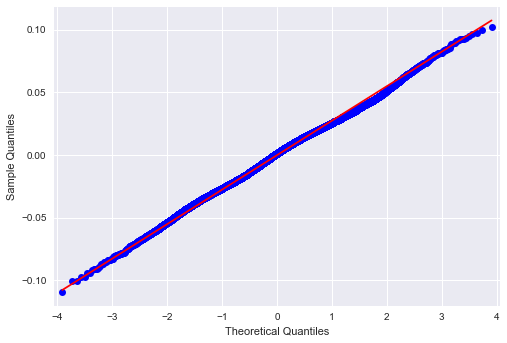

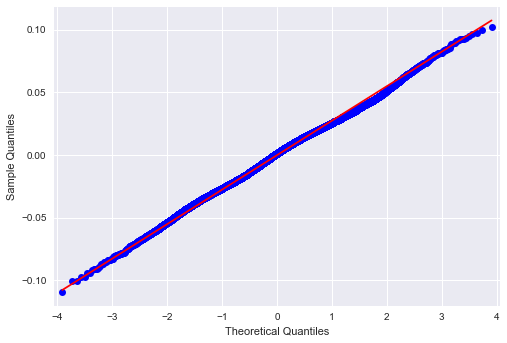

In [889]:
qqplot(modelnhclp.resid, line = 'q')

### MODEL NUMERO TRES - NORMALIZING ALL